# **Proyecto FINAL | Gustavo Recalde**

# **Optimización de Portafolios de Inversión usando Redes LSTM y PLN**


## **Dependencias y librerias**

In [ ]:
!pip install pytorch-lightning
!pip install vaderSentiment
!pip install praw
!pip install asyncpraw
!pip install requests beautifulsoup4 lxml transformers
!pip install torch transformers tokenizers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.5/890.5 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 4.3 MB/s eta 0:00:00


### Librerias

In [ ]:
# Importar librerías y configurar la semilla
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.optimize import minimize
import os

# Configuración de la semilla para reproducibilidad
np.random.seed(4)
torch.manual_seed(4)


## **Recolección y Procesamiento de Datos**

[*********************100%***********************]  1 of 1 completed


Datos para AMZN descargados.


[*********************100%***********************]  1 of 1 completed


Datos para GOOGL descargados.


[*********************100%***********************]  1 of 1 completed


Datos para NVDA descargados.


[*********************100%***********************]  1 of 1 completed


Datos para AAPL descargados.


[*********************100%***********************]  1 of 1 completed


Datos para NFLX descargados.


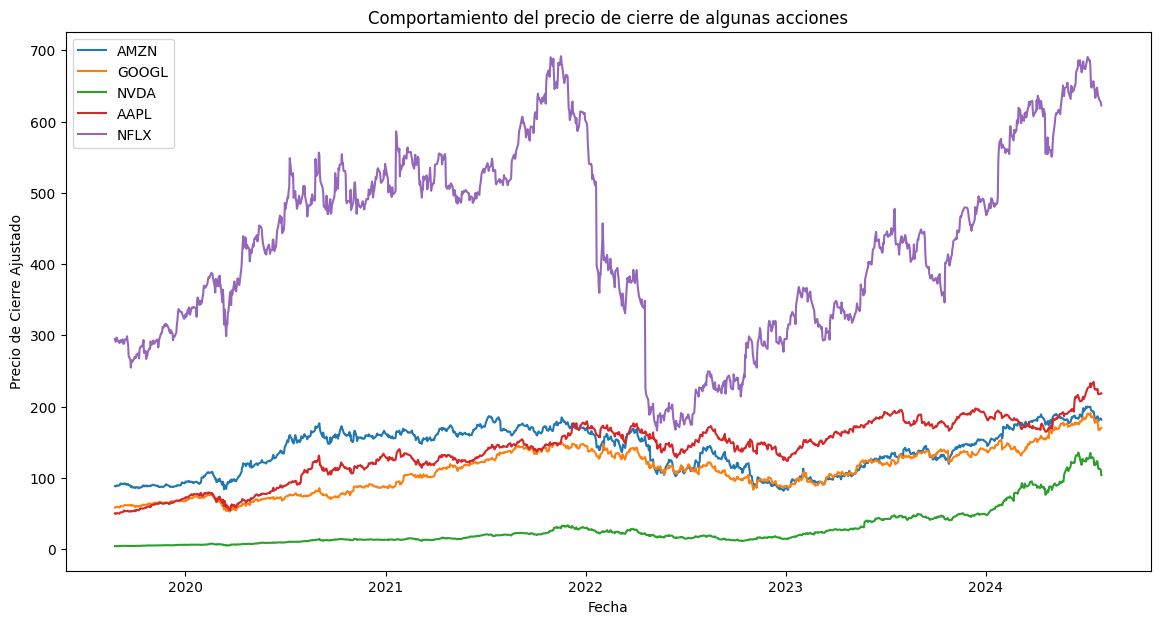

In [ ]:
# Recolección y procesamiento de datos

# Lista de tickers
tickers = ['AMZN', 'GOOGL', 'NVDA', 'AAPL', 'NFLX']

# Descargar datos de Yahoo Finance para cada ticker
def download_stock_data(ticker):
    data = yf.download(ticker, start='2019-06-01', end='2024-07-31')
    data['MA_10'] = data['Adj Close'].rolling(window=10).mean()
    data['MA_30'] = data['Adj Close'].rolling(window=30).mean()
    data['MA_60'] = data['Adj Close'].rolling(window=60).mean()
    data.dropna(inplace=True)  # Eliminar filas con valores NaN debido al cálculo de medias móviles
    return data

# Descargar y almacenar datos para cada ticker
stock_data = {}
for ticker in tickers:
    stock_data[ticker] = download_stock_data(ticker)
    print(f"Datos para {ticker} descargados.")

# Graficar el comportamiento del precio de cierre ajustado de todas las acciones
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(stock_data[ticker].index, stock_data[ticker]['Adj Close'], label=ticker)
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre Ajustado')
plt.title('Comportamiento del precio de cierre de algunas acciones')
plt.legend()
plt.show()


## **Funciones Auxiliares**

In [ ]:
# Función para graficar las predicciones con fechas en el eje x
def graficar_predicciones(real, prediccion, dates, ticker):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, real, color='red', label='Valor real de la acción')
    plt.plot(dates[len(dates) - len(prediccion):], prediccion, color='blue', label='Predicción de la acción')
    plt.xlabel('Fecha')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.title(f'Predicciones para {ticker}')
    plt.xticks(rotation=45)
    plt.show()

# Callback para registrar la pérdida durante el entrenamiento
class LossLogger(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        logs = trainer.logged_metrics
        epoch = trainer.current_epoch
        loss = logs['train_loss_epoch'].item()
        if not hasattr(self, 'losses'):
            self.losses = []
        self.losses.append((epoch, loss))

# Función para graficar la pérdida durante el entrenamiento
def plot_loss(callback, ticker):
    epochs, losses = zip(*callback.losses)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, losses, label='Pérdida de Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title(f'Pérdida durante el Entrenamiento para {ticker}')
    plt.legend()
    plt.show()

# **Modelo 1. LSTM Usando unicamente datos financieros**

In [ ]:
# Definir el modelo LSTM en PyTorch Lightning

class LSTMModel(pl.LightningModule):
    def __init__(self, input_size=4, hidden_layer_size=100, output_size=1, lr=0.001):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.lr = lr
        self.criterion = nn.MSELoss()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss_epoch', loss, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


## **Entrenamiento y prediccion**

In [ ]:
# Función para entrenar modelos y hacer predicciones para cada ticker

def train_and_predict(ticker):
    data = stock_data[ticker]

    # Sets de entrenamiento y validación
    set_entrenamiento = data[:'2023-06-30'].loc[:, ['Adj Close', 'MA_10', 'MA_30', 'MA_60']]
    set_validacion = data['2023-07-01':].loc[:, ['Adj Close', 'MA_10', 'MA_30', 'MA_60']]

    # Normalización del set de entrenamiento y validación
    sc = MinMaxScaler(feature_range=(0, 1))
    set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)
    set_validacion_escalado = sc.transform(set_validacion)

    # Preparar datos para PyTorch
    time_step = 60
    X_train = []
    Y_train = []
    m = len(set_entrenamiento_escalado)

    for i in range(time_step, m):
        X_train.append(set_entrenamiento_escalado[i-time_step:i])
        Y_train.append(set_entrenamiento_escalado[i, 0])  # Usar solo la columna 'Adj Close'

    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)

    train_dataset = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    model_path = f'{ticker}_model.pth'
    if os.path.exists(model_path):
        model = LSTMModel()
        model.load_state_dict(torch.load(model_path))
        print(f"Modelo cargado para {ticker}.")
        final_loss = None  # No tenemos pérdida final al cargar el modelo
    else:
        # Entrenamiento del modelo
        model = LSTMModel()
        loss_logger = LossLogger()
        trainer = pl.Trainer(max_epochs=20, logger=False, callbacks=[loss_logger])
        trainer.fit(model, train_loader)

        # Guardar el modelo
        torch.save(model.state_dict(), model_path)
        print(f"Modelo guardado para {ticker}.")

        # Graficar la pérdida durante el entrenamiento
        plot_loss(loss_logger, ticker)
        final_loss = loss_logger.losses[-1][1] if hasattr(loss_logger, 'losses') else None

    # Preparar datos de validación para la predicción
    X_test = []
    for i in range(time_step, len(set_validacion_escalado)):
        X_test.append(set_validacion_escalado[i-time_step:i])

    X_test = np.array(X_test)
    X_test = torch.tensor(X_test, dtype=torch.float32)

    # Predicción
    model.eval()
    with torch.no_grad():
        prediccion = model(X_test).numpy()

    prediccion = sc.inverse_transform(np.concatenate([prediccion, np.zeros((prediccion.shape[0], 3))], axis=1))[:, 0]

    # Graficar las predicciones
    graficar_predicciones(set_validacion.values[:, 0], prediccion, set_validacion.index, ticker)

    # Calcular métricas de evaluación
    mse = mean_squared_error(set_validacion.values[time_step:, 0], prediccion)
    mae = mean_absolute_error(set_validacion.values[time_step:, 0], prediccion)
    r2 = r2_score(set_validacion.values[time_step:, 0], prediccion)

    print(f"Mean Squared Error (MSE) para {ticker}: {mse}")
    print(f"Mean Absolute Error (MAE) para {ticker}: {mae}")
    print(f"R^2 Score para {ticker}: {r2}")

    return {
        "ticker": ticker,
        "mse": mse,
        "mae": mae,
        "r2": r2,
        "final_loss": final_loss,
        "prediccion": prediccion  # Añadir las predicciones a los resultados
    }


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Procesando AMZN...


INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 42.4 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
42.5 K    Trainable params
0         Non-trainable params
42.5 K    Total params
0.170     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Modelo guardado para AMZN.


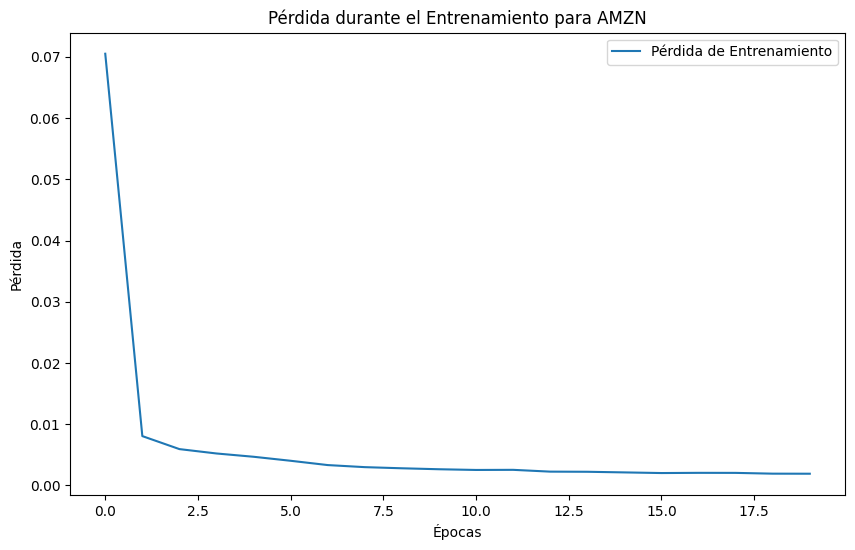

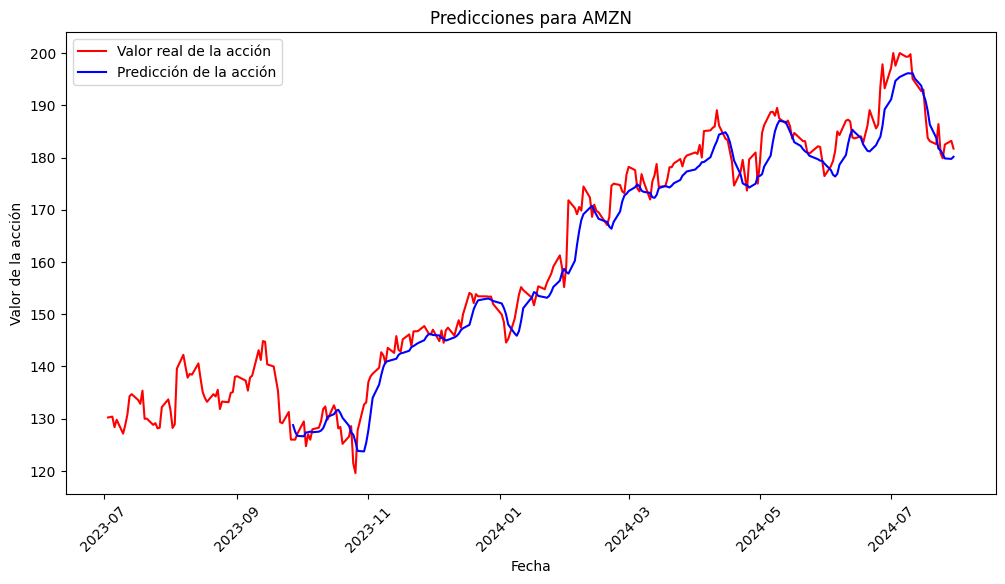

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 42.4 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
42.5 K    Trainable params
0         Non-trainable params
42.5 K    Total params
0.170     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Mean Squared Error (MSE) para AMZN: 14.764645429772429
Mean Absolute Error (MAE) para AMZN: 2.989071662285819
R^2 Score para AMZN: 0.9669296602406747
Procesando GOOGL...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Modelo guardado para GOOGL.


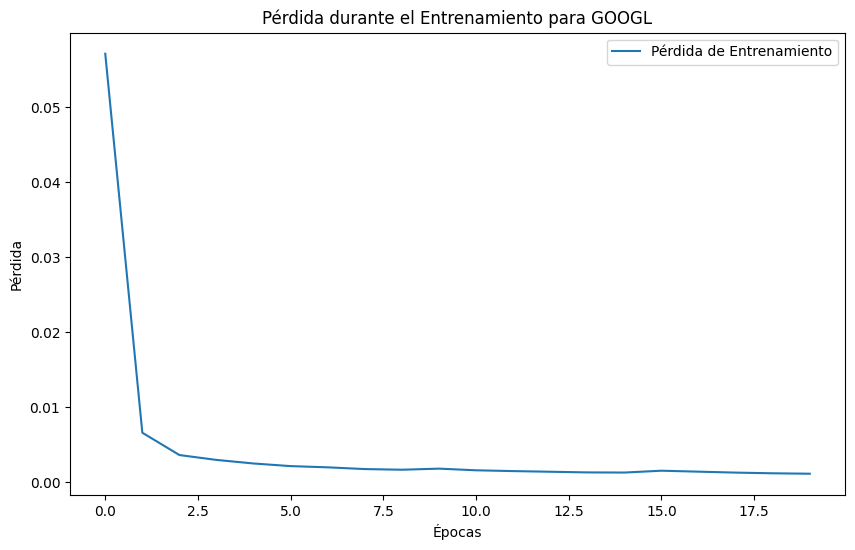

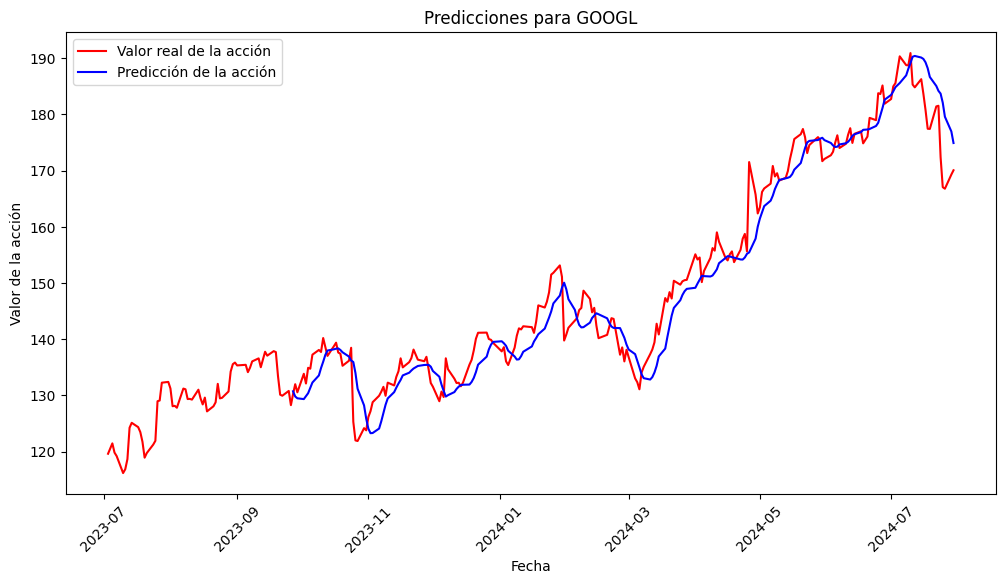

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 42.4 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
42.5 K    Trainable params
0         Non-trainable params
42.5 K    Total params
0.170     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Mean Squared Error (MSE) para GOOGL: 18.694204346098534
Mean Absolute Error (MAE) para GOOGL: 3.352091001764714
R^2 Score para GOOGL: 0.9443343633928728
Procesando NVDA...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Modelo guardado para NVDA.


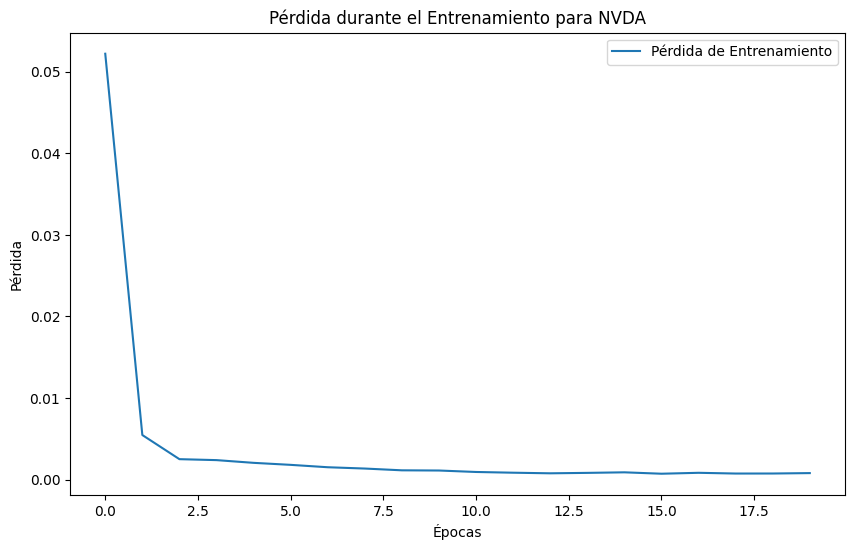

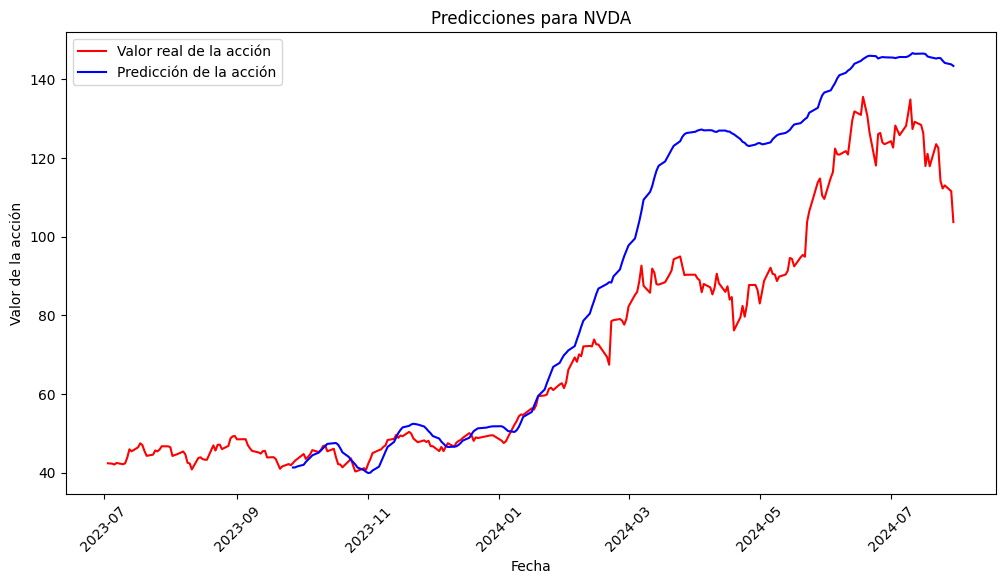

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 42.4 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
42.5 K    Trainable params
0         Non-trainable params
42.5 K    Total params
0.170     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Mean Squared Error (MSE) para NVDA: 455.8087677932866
Mean Absolute Error (MAE) para NVDA: 15.877174012205476
R^2 Score para NVDA: 0.45406735734660286
Procesando AAPL...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Modelo guardado para AAPL.


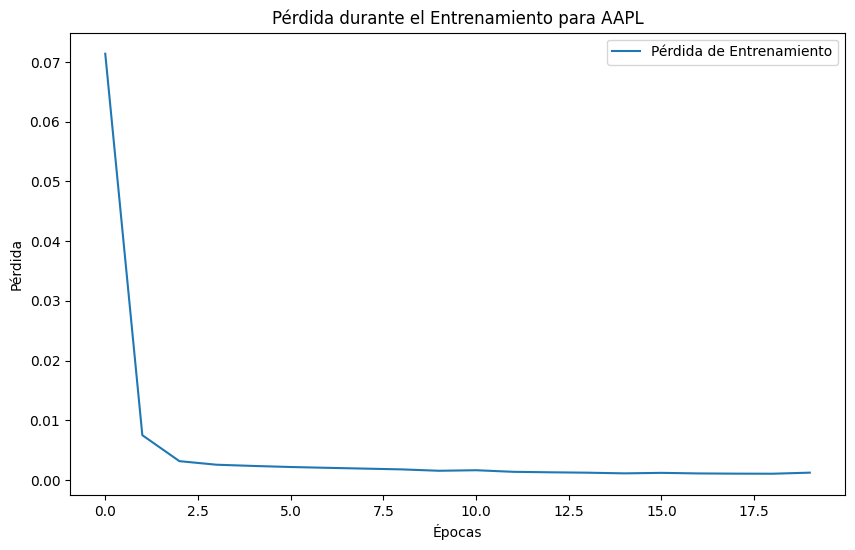

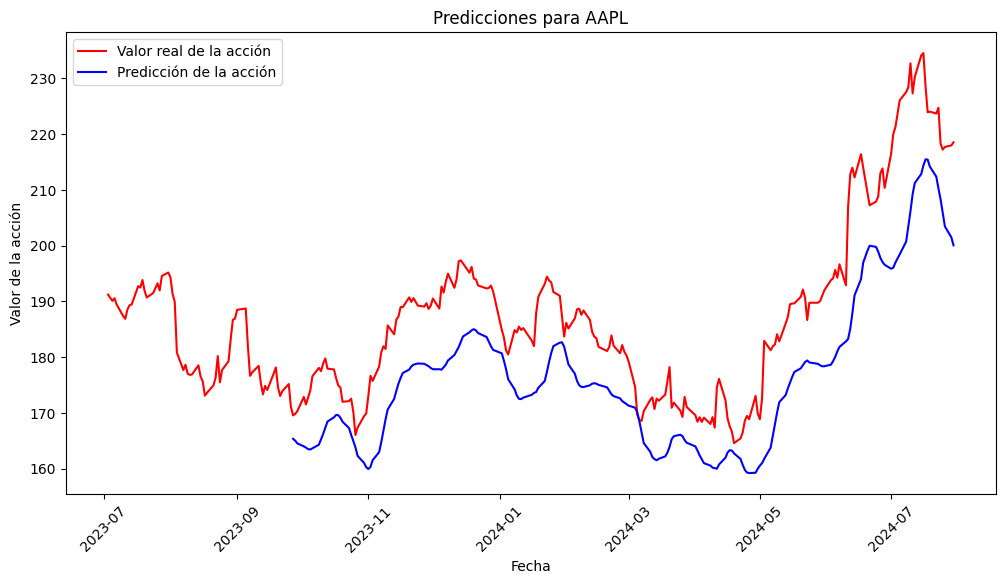

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 42.4 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
42.5 K    Trainable params
0         Non-trainable params
42.5 K    Total params
0.170     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Mean Squared Error (MSE) para AAPL: 154.91249844871658
Mean Absolute Error (MAE) para AAPL: 11.320724309724744
R^2 Score para AAPL: 0.4365038825226577
Procesando NFLX...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Modelo guardado para NFLX.


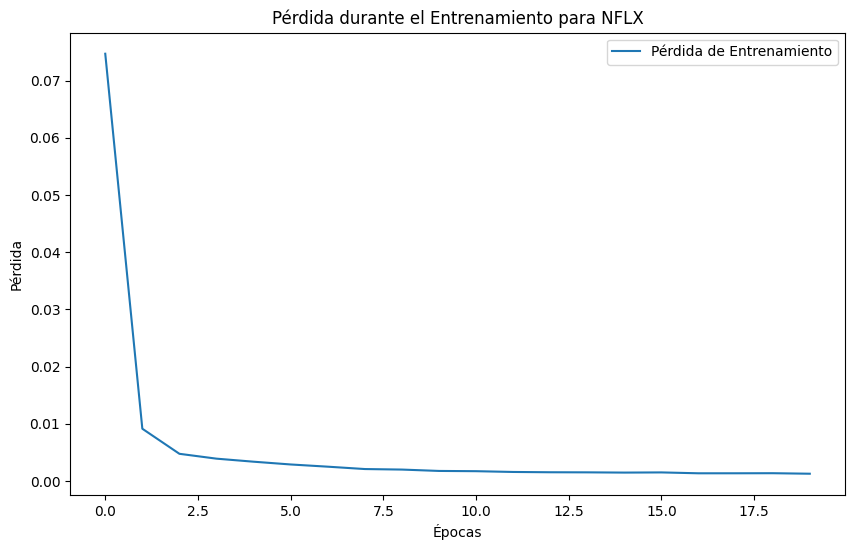

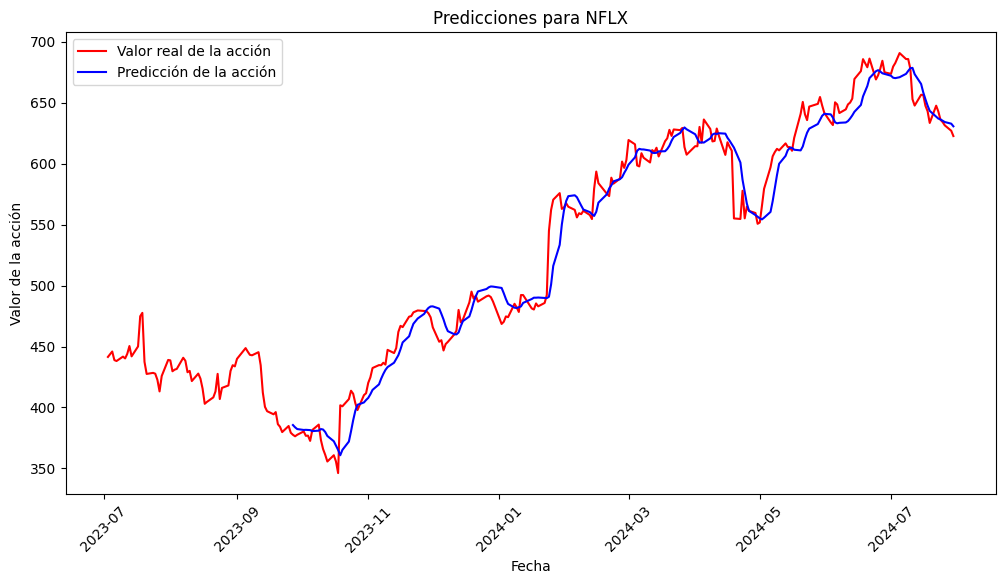

Mean Squared Error (MSE) para NFLX: 267.25139269228305
Mean Absolute Error (MAE) para NFLX: 11.963359756041777
R^2 Score para NFLX: 0.969848522236064
  ticker         mse        mae        r2  final_loss
0   AMZN   14.764645   2.989072  0.966930    0.001908
1  GOOGL   18.694204   3.352091  0.944334    0.001140
2   NVDA  455.808768  15.877174  0.454067    0.000789
3   AAPL  154.912498  11.320724  0.436504    0.001229
4   NFLX  267.251393  11.963360  0.969849    0.001282
           AMZN       GOOGL        NVDA        AAPL        NFLX
0    128.753839  130.719863   41.335356  165.361557  385.592727
1    127.459223  129.795071   41.346244  165.023881  383.720299
2    126.694707  129.472647   41.593795  164.528571  382.288878
3    126.614486  129.331570   42.026043  164.010383  381.550114
4    127.342717  129.862370   42.749735  163.779891  381.661849
..          ...         ...         ...         ...         ...
206  181.350189  183.708156  145.412068  208.301220  636.225228
207  180.62526

In [ ]:
# Almacenar resultados
resultados = []
predicciones = {}

# Hacer predicciones para cada ticker y almacenar métricas
for ticker in tickers:
    print(f"Procesando {ticker}...")
    resultado = train_and_predict(ticker)
    resultados.append(resultado)
    predicciones[ticker] = resultado['prediccion']

# Crear DataFrame con resultados
resultados_df = pd.DataFrame(resultados)
resultados_df = resultados_df[['ticker', 'mse', 'mae', 'r2', 'final_loss']]

# Mostrar la tabla de resultados
print(resultados_df)

# Guardar las predicciones futuras en un DataFrame
future_prices_df = pd.DataFrame(predicciones)
print(future_prices_df)


# **MODELO 2. INCLUSION DE ANALISIS DE SENTIMEINTOS CON VADER**


In [ ]:
# Importar librerías necesarias

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nest_asyncio
import asyncio
import asyncpraw
import datetime

# Descargar datos necesarios para NLTK
nltk.download('vader_lexicon')

# Aplicar nest_asyncio para permitir bucles asíncronos
nest_asyncio.apply()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


### Definición de Tickers y Función para Descargar Datos Financieros (NO)

In [ ]:
# Lista de tickers
tickers = ['AMZN', 'GOOGL', 'NVDA', 'AAPL', 'NFLX']

# Función para descargar datos financieros
def download_stock_data(ticker):
    data = yf.download(ticker, start='2019-06-01', end='2024-07-31')
    data['MA_10'] = data['Adj Close'].rolling(window=10).mean()
    data['MA_30'] = data['Adj Close'].rolling(window=30).mean()
    data['MA_60'] = data['Adj Close'].rolling(window=60).mean()
    data.dropna(inplace=True)
    return data

# Descargar datos para cada ticker
stock_data = {}
for ticker in tickers:
    data = download_stock_data(ticker)
    stock_data[ticker] = data
    print(f"Datos descargados para {ticker}.")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Datos descargados para AMZN.
Datos descargados para GOOGL.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Datos descargados para NVDA.
Datos descargados para AAPL.
Datos descargados para NFLX.


### **Obtención de Datos de Sentimiento con reddit**

In [ ]:
# Configuración de las credenciales de Reddit
cliente_id = "H3cf4dEtELCFz7w3z6eIKw"       # Reemplaza con tu client_id
cliente_secret = "H3cf4dEtELCFz7w3z6eIKw"  # Reemplaza con tu client_secret
usuario = "RoutineStrain7301"       # Reemplaza con tu nombre de usuario de Reddit
contraseña = "Tavinr1717*"      # Reemplaza con tu contraseña de Reddit
user_agent = "proyectogustav"   # Reemplaza con tu user_agent (por ejemplo, el nombre de tu aplicación)



### **Función Asíncrona para Obtener Datos de Reddit y Calcular el Sentimiento**

In [ ]:
nest_asyncio.apply()

async def obtener_reddit_async(ticker, cliente_id, cliente_secret, usuario, contraseña, user_agent, subreddit='WallStreetBets', limite=100):
    reddit = asyncpraw.Reddit(client_id=cliente_id,
                              client_secret=cliente_secret,
                              user_agent=user_agent,
                              username=usuario,
                              password=contraseña)

    subreddit = await reddit.subreddit(subreddit)
    publicaciones = subreddit.search(ticker, limit=limite)
    datos = []
    async for post in publicaciones:
        datos.append({
            'titulo': post.title,
            'cuerpo': post.selftext,
            'fecha': post.created_utc
        })
    await reddit.close()
    return datos


In [ ]:
def agregar_sentimiento_reddit(stock_data):
    for ticker in tickers:
        data = stock_data[ticker]
        print(f"Obteniendo publicaciones de Reddit para {ticker}...")

        # Ejecutar la función asíncrona para obtener las publicaciones
        publicaciones = asyncio.run(obtener_reddit_async(
            ticker,
            cliente_id,
            cliente_secret,
            usuario,
            contraseña,
            user_agent,
            subreddit='WallStreetBets',
            limite=100
        ))

        # Procesar las publicaciones para calcular el sentimiento
        sia = SentimentIntensityAnalyzer()
        sentimiento_por_fecha = {}
        for post in publicaciones:
            fecha = datetime.datetime.utcfromtimestamp(post['fecha']).strftime('%Y-%m-%d')
            full_text = post['titulo'] + ' ' + (post['cuerpo'] or '')
            sentimiento = sia.polarity_scores(full_text)['compound']
            if fecha in sentimiento_por_fecha:
                sentimiento_por_fecha[fecha].append(sentimiento)
            else:
                sentimiento_por_fecha[fecha] = [sentimiento]

        # Promediar el sentimiento por fecha
        for fecha in sentimiento_por_fecha:
            sentimiento_por_fecha[fecha] = np.mean(sentimiento_por_fecha[fecha])

        # Crear una columna de sentimiento alineada con las fechas del mercado
        sentimientos = []
        for date in data.index.strftime('%Y-%m-%d'):
            if date in sentimiento_por_fecha:
                sentimientos.append(sentimiento_por_fecha[date])
            else:
                sentimientos.append(0)  # Podria optar por usar el último valor conocido o interpolar
        data['sentimiento_reddit'] = sentimientos
        stock_data[ticker] = data
        print(f"Sentimiento de Reddit agregado para {ticker}.")
    return stock_data


In [ ]:
async def test_reddit_auth():
    reddit = asyncpraw.Reddit(client_id=cliente_id,
                              client_secret=cliente_secret,
                              user_agent=user_agent,
                              username=usuario,
                              password=contraseña)

    try:
        subreddit = await reddit.subreddit('WallStreetBets')
        print(f"Acceso exitoso al subreddit: {subreddit.display_name}")
    except Exception as e:
        print(f"Error de autenticación: {e}")

asyncio.get_event_loop().run_until_complete(test_reddit_auth())


Acceso exitoso al subreddit: WallStreetBets


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nest_asyncio.apply()

# Tus credenciales de Reddit
cliente_id = "H3cf4dEtELCFz7w3z6eIKw"
cliente_secret = "lxNt3eDn3Y1XA57EIq3_Q92AQ_Ntyw"
usuario = "RoutineStrain7301"
contraseña = "Tavinr1717*"
user_agent = "proyectogustav"

# Lista de tickers (asegúrate de que está definida)
#tickers = ['AMZN', 'GOOGL', 'NVDA', 'AAPL', 'NFLX']

async def obtener_reddit_async(ticker, subreddit_nombre='WallStreetBets', limite=1000):
    async with asyncpraw.Reddit(client_id=cliente_id,
                                client_secret=cliente_secret,
                                user_agent=user_agent,
                                username=usuario,
                                password=contraseña) as reddit:
        subreddit = await reddit.subreddit(subreddit_nombre)
        publicaciones = subreddit.search(ticker, limit=limite)
        datos = []
        async for post in publicaciones:
            datos.append({
                'titulo': post.title,
                'cuerpo': post.selftext,
                'fecha': post.created_utc
            })
        return datos

def agregar_sentimiento_reddit(stock_data):
    sia = SentimentIntensityAnalyzer()

    async def process_tickers():
        for ticker in tickers:
            data = stock_data[ticker]
            print(f"Obteniendo publicaciones de Reddit para {ticker}...")

            publicaciones = await obtener_reddit_async(ticker, subreddit_nombre='WallStreetBets', limite=1000)

            sentimiento_por_fecha = {}
            for post in publicaciones:
                fecha = datetime.datetime.utcfromtimestamp(post['fecha']).strftime('%Y-%m-%d')
                full_text = post['titulo'] + ' ' + (post['cuerpo'] or '')
                sentimiento = sia.polarity_scores(full_text)['compound']
                if fecha in sentimiento_por_fecha:
                    sentimiento_por_fecha[fecha].append(sentimiento)
                else:
                    sentimiento_por_fecha[fecha] = [sentimiento]

            # Promediar el sentimiento por fecha
            for fecha in sentimiento_por_fecha:
                sentimiento_por_fecha[fecha] = np.mean(sentimiento_por_fecha[fecha])

            # Crear una columna de sentimiento alineada con las fechas del mercado
            sentimientos = []
            for date in data.index.strftime('%Y-%m-%d'):
                if date in sentimiento_por_fecha:
                    sentimientos.append(sentimiento_por_fecha[date])
                else:
                    sentimientos.append(0)
            data['sentimiento_reddit'] = sentimientos
            stock_data[ticker] = data
            print(f"Sentimiento de Reddit agregado para {ticker}.")

    # Ejecutar la función asíncrona
    asyncio.run(process_tickers())
    return stock_data

# Asegúrate de que stock_data está definido y contiene los datos financieros
# Por ejemplo, si ya descargaste los datos financieros:
# stock_data = {'AMZN': amzn_data, 'GOOGL': googl_data, ...}

# Agregar sentimiento de Reddit a los datos financieros
stock_data = agregar_sentimiento_reddit(stock_data)


Obteniendo publicaciones de Reddit para AMZN...
Sentimiento de Reddit agregado para AMZN.
Obteniendo publicaciones de Reddit para GOOGL...
Sentimiento de Reddit agregado para GOOGL.
Obteniendo publicaciones de Reddit para NVDA...
Sentimiento de Reddit agregado para NVDA.
Obteniendo publicaciones de Reddit para AAPL...
Sentimiento de Reddit agregado para AAPL.
Obteniendo publicaciones de Reddit para NFLX...
Sentimiento de Reddit agregado para NFLX.


Código para Preparar los Datos

In [ ]:
# Definir el dispositivo (CPU o GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def preparar_datos_lstm(stock_data, ticker, features, time_step=60):
    data = stock_data[ticker]

    # Eliminar filas con valores NaN
    data = data.dropna(subset=features)

    # Dividir datos en entrenamiento y validación
    train_data = data.loc[:'2023-06-30', features]
    val_data = data.loc['2023-07-01':, features]

    # Escalado de los datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data)
    val_scaled = scaler.transform(val_data)

    # Crear secuencias para LSTM
    X_train, Y_train = [], []
    for i in range(time_step, len(train_scaled)):
        X_train.append(train_scaled[i-time_step:i])
        Y_train.append(train_scaled[i, 0])  # Precio de cierre ajustado

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)

    # Preparar datos de validación
    X_val, Y_val = [], []
    for i in range(time_step, len(val_scaled)):
        X_val.append(val_scaled[i-time_step:i])
        Y_val.append(val_scaled[i, 0])

    X_val = np.array(X_val)
    Y_val = np.array(Y_val)

    return X_train, Y_train, X_val, Y_val, scaler, val_data.index[time_step:]


Entrenar el Modelo y Realizar Predicciones

In [ ]:
def train_and_evaluate_model(ticker):
    print(f"\nEntrenando modelo para {ticker}...")
    features = ['Adj Close', 'MA_10', 'MA_30', 'MA_60', 'sentimiento_reddit']

    # Preparar los datos
    X_train, Y_train, X_val, Y_val, scaler, dates = preparar_datos_lstm(stock_data, ticker, features)

    # Convertir a tensores y mover al dispositivo
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32).unsqueeze(1).to(device)

    # Crear DataLoader
    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Instanciar el modelo
    model = LSTMModel(input_size=len(features)).to(device)

    # Entrenar el modelo
    trainer = pl.Trainer(max_epochs=20, logger=False, enable_checkpointing=False)
    trainer.fit(model, train_loader)

    # Realizar predicciones
    model.eval()
    with torch.no_grad():
        predictions = model(X_val_tensor).cpu().numpy()

    # Desescalar las predicciones y los valores reales
    predictions_extended = np.concatenate([predictions, np.zeros((predictions.shape[0], len(features)-1))], axis=1)
    predictions_descaled = scaler.inverse_transform(predictions_extended)[:, 0]

    Y_val_extended = np.concatenate([Y_val.reshape(-1, 1), np.zeros((Y_val.shape[0], len(features)-1))], axis=1)
    Y_val_descaled = scaler.inverse_transform(Y_val_extended)[:, 0]

    # Calcular métricas
    mse = mean_squared_error(Y_val_descaled, predictions_descaled)
    mae = mean_absolute_error(Y_val_descaled, predictions_descaled)
    r2 = r2_score(Y_val_descaled, predictions_descaled)

    print(f"Métricas para {ticker}:")
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print(f"R²: {r2}")

    # Graficar resultados
    plt.figure(figsize=(12, 6))
    plt.plot(dates, Y_val_descaled, color='red', label='Valor Real')
    plt.plot(dates, predictions_descaled, color='blue', label='Predicción')
    plt.title(f"Predicción del Precio de {ticker} utilizando LSTM con Sentimiento de Reddit")
    plt.xlabel('Fecha')
    plt.ylabel('Precio de Cierre Ajustado')
    plt.legend()
    plt.show()

    # Retornar métricas
    return {
        'ticker': ticker,
        'mse': mse,
        'mae': mae,
        'r2': r2
    }


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 42.8 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
42.9 K    Trainable params
0         Non-trainable params
42.9 K    Total params
0.172     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode



Entrenando modelo para AMZN...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Métricas para AMZN:
MSE: 19.292299138473396
MAE: 3.6259490446848304
R²: 0.9567884721456743


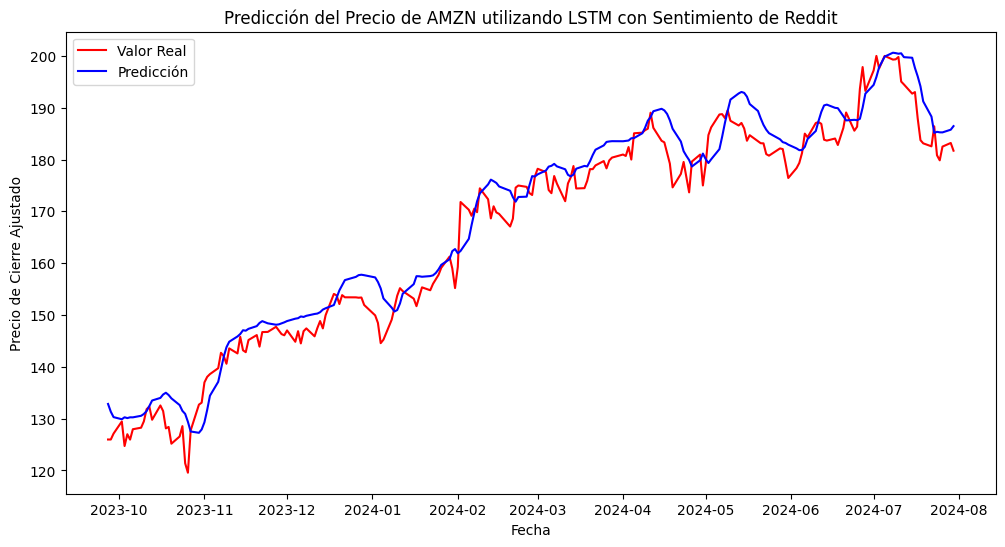

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 42.8 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
42.9 K    Trainable params
0         Non-trainable params
42.9 K    Total params
0.172     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode



Entrenando modelo para GOOGL...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Métricas para GOOGL:
MSE: 54.10022074549618
MAE: 6.496369296879299
R²: 0.8389060495632884


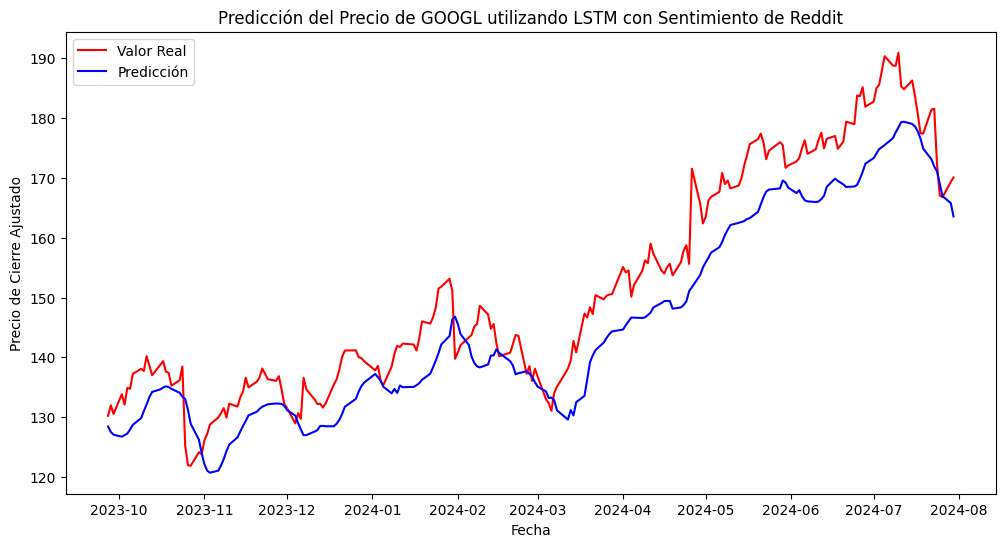

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 42.8 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
42.9 K    Trainable params
0         Non-trainable params
42.9 K    Total params
0.172     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode



Entrenando modelo para NVDA...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Métricas para NVDA:
MSE: 36.48801676918624
MAE: 4.680228799500629
R²: 0.9562974632620116


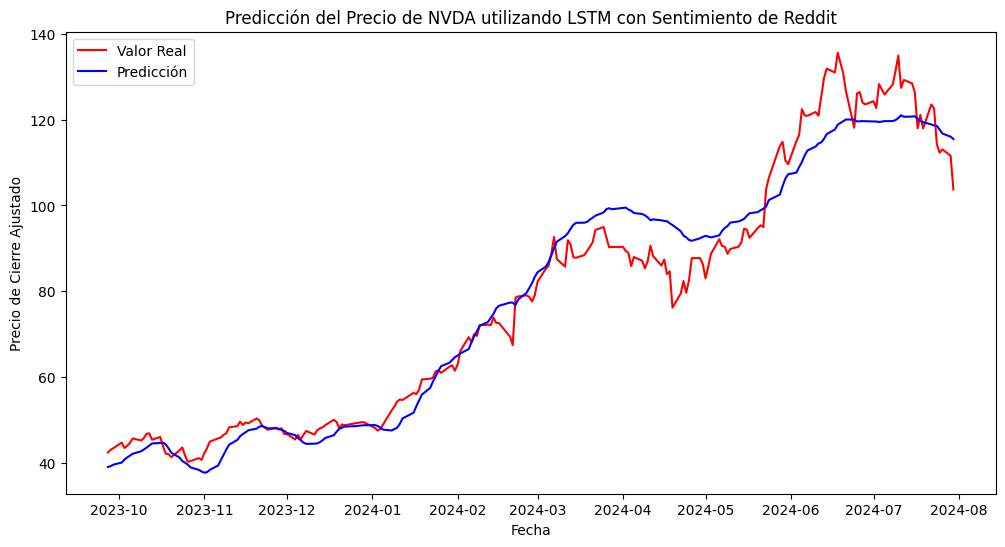

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 42.8 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
42.9 K    Trainable params
0         Non-trainable params
42.9 K    Total params
0.172     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode



Entrenando modelo para AAPL...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Métricas para AAPL:
MSE: 55.56131353994239
MAE: 5.64760093412307
R²: 0.7978950389721883


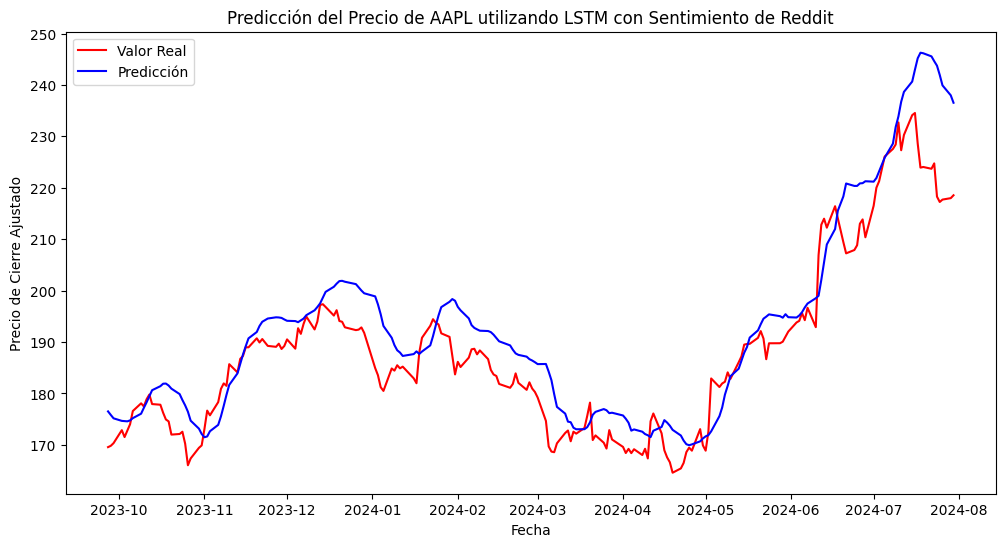

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 42.8 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
42.9 K    Trainable params
0         Non-trainable params
42.9 K    Total params
0.172     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode



Entrenando modelo para NFLX...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Métricas para NFLX:
MSE: 265.52772047198954
MAE: 11.868395585604562
R²: 0.9700429880687728


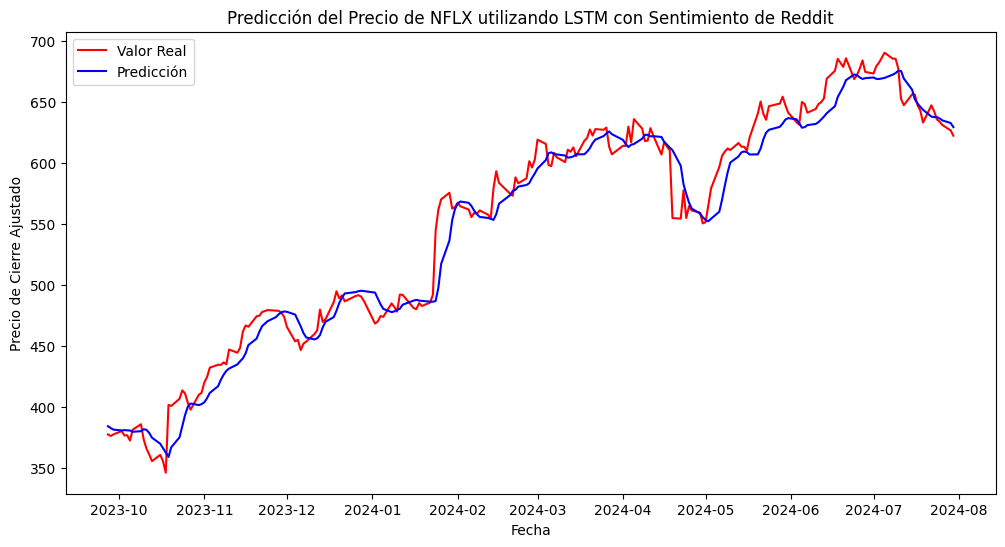

In [ ]:
# Lista para almacenar los resultados
results = []

for ticker in tickers:
    result = train_and_evaluate_model(ticker)
    results.append(result)


Visualizar las Métricas de Rendimiento

In [ ]:
# Crear un DataFrame con las métricas
metrics_df = pd.DataFrame(results)

print("\nMétricas de Rendimiento:")
print(metrics_df)



Métricas de Rendimiento:
  ticker         mse        mae        r2
0   AMZN   19.292299   3.625949  0.956788
1  GOOGL   54.100221   6.496369  0.838906
2   NVDA   36.488017   4.680229  0.956297
3   AAPL   55.561314   5.647601  0.797895
4   NFLX  265.527720  11.868396  0.970043


# **Modelo 3. Analisis de sentimientos con TRANSFORMERS**

### **Extracción de Noticias de Yahoo Finance**

In [ ]:
import requests
from bs4 import BeautifulSoup
import time

def obtener_noticias_yahoo(ticker, start_date, end_date):
    noticias_por_fecha = {}
    base_url = f"https://finance.yahoo.com/quote/{ticker}/news?p={ticker}"

    # Convertir fechas a objetos datetime
    start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')

    # Realizar solicitud a la página de noticias
    response = requests.get(base_url)
    soup = BeautifulSoup(response.content, 'lxml')

    # Encontrar todas las noticias
    articles = soup.find_all('li', {'class': 'js-stream-content'})

    for article in articles:
        # Obtener título y enlace
        title_tag = article.find('h3')
        if title_tag:
            title = title_tag.get_text()
            link = 'https://finance.yahoo.com' + title_tag.find('a')['href']

            # Obtener fecha de la noticia
            time_tag = article.find('span', {'class': 'C(#959595) Fz(11px) D(ib) Mb(6px)'})
            if time_tag:
                time_text = time_tag.get_text()
                # Parsear fecha (puede ser "hace X horas" o fecha exacta)
                noticia_fecha = parse_fecha_noticia(time_text)

                if noticia_fecha and start_date <= noticia_fecha <= end_date:
                    # Obtener contenido de la noticia
                    contenido = obtener_contenido_noticia(link)
                    if contenido:
                        fecha_str = noticia_fecha.strftime('%Y-%m-%d')
                        if fecha_str in noticias_por_fecha:
                            noticias_por_fecha[fecha_str].append(contenido)
                        else:
                            noticias_por_fecha[fecha_str] = [contenido]

    return noticias_por_fecha

def parse_fecha_noticia(time_text):
    # Función para convertir el texto de fecha en un objeto datetime
    try:
        if 'ago' in time_text:
            # Noticias recientes (e.g., "2 hours ago")
            now = datetime.datetime.now()
            if 'hour' in time_text:
                hours = int(time_text.split(' ')[0])
                noticia_fecha = now - datetime.timedelta(hours=hours)
            elif 'minute' in time_text:
                minutes = int(time_text.split(' ')[0])
                noticia_fecha = now - datetime.timedelta(minutes=minutes)
            else:
                # Otros casos
                noticia_fecha = now
        else:
            # Fecha en formato específico (e.g., "August 24, 2023")
            noticia_fecha = datetime.datetime.strptime(time_text, '%B %d, %Y')
        return noticia_fecha
    except Exception as e:
        return None

def obtener_contenido_noticia(link):
    # Función para obtener el contenido de la noticia dado el enlace
    try:
        response = requests.get(link)
        soup = BeautifulSoup(response.content, 'lxml')
        content_tags = soup.find_all('p')
        content = ' '.join([tag.get_text() for tag in content_tags])
        return content
    except Exception as e:
        return None


### **Análisis de Sentimiento con Transformers**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Cargar el modelo y el tokenizador de FinBERT
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

def analizar_sentimiento_finbert(texto):
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    # Obtener las probabilidades
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    # Mapear etiquetas
    labels = {0: 'negative', 1: 'neutral', 2: 'positive'}
    # Obtener la etiqueta con mayor probabilidad
    sentiment = labels[int(torch.argmax(probabilities))]
    # Retornar la probabilidad de sentimiento positivo
    positive_score = probabilities[0][2].item()
    negative_score = probabilities[0][0].item()
    neutral_score = probabilities[0][1].item()
    # Puedes definir el sentimiento como positivo menos negativo, o como prefieras
    sentiment_score = positive_score - negative_score
    return sentiment_score


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

### **Integrar Datos de Sentimiento al Conjunto de Datos Financiero**

In [ ]:
def agregar_sentimiento_noticias(stock_data):
    for ticker in tickers:
        data = stock_data[ticker]
        start_date = data.index.min().strftime('%Y-%m-%d')
        end_date = data.index.max().strftime('%Y-%m-%d')
        print(f"Obteniendo noticias de Yahoo Finance para {ticker} desde {start_date} hasta {end_date}...")

        noticias_por_fecha = obtener_noticias_yahoo(ticker, start_date, end_date)

        sentimiento_por_fecha = {}
        for fecha, noticias in noticias_por_fecha.items():
            sentimiento_diario = []
            for noticia in noticias:
                sentimiento = analizar_sentimiento_finbert(noticia)
                sentimiento_diario.append(sentimiento)
            # Promediar el sentimiento diario
            sentimiento_por_fecha[fecha] = np.mean(sentimiento_diario)

        # Crear una columna de sentimiento alineada con las fechas del mercado
        sentimientos = []
        for date in data.index.strftime('%Y-%m-%d'):
            if date in sentimiento_por_fecha:
                sentimientos.append(sentimiento_por_fecha[date])
            else:
                sentimientos.append(0)
        data['sentimiento_noticias'] = sentimientos
        stock_data[ticker] = data
        print(f"Sentimiento de noticias agregado para {ticker}.")
    return stock_data


### **Actualizar el Modelo para Incluir el Sentimiento de Noticias**

In [ ]:
def preparar_datos_lstm(stock_data, ticker, features, time_step=60):
    data = stock_data[ticker]

    # Eliminar filas con valores NaN
    data = data.dropna(subset=features)

    # Dividir datos en entrenamiento y validación
    train_data = data.loc[:'2023-06-30', features]
    val_data = data.loc['2023-07-01':, features]

    # Escalado de los datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data)
    val_scaled = scaler.transform(val_data)

    # Crear secuencias para LSTM
    X_train, Y_train = [], []
    for i in range(time_step, len(train_scaled)):
        X_train.append(train_scaled[i-time_step:i])
        Y_train.append(train_scaled[i, 0])  # Precio de cierre ajustado

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)

    # Preparar datos de validación
    X_val, Y_val = [], []
    for i in range(time_step, len(val_scaled)):
        X_val.append(val_scaled[i-time_step:i])
        Y_val.append(val_scaled[i, 0])

    X_val = np.array(X_val)
    Y_val = np.array(Y_val)

    return X_train, Y_train, X_val, Y_val, scaler, val_data.index[time_step:]


### **Entrenar y Evaluar el Modelo**

In [ ]:
def train_and_evaluate_model(ticker):
    print(f"\nEntrenando modelo para {ticker}...")
    features = ['Adj Close', 'MA_10', 'MA_30', 'MA_60', 'sentimiento_reddit', 'sentimiento_noticias']

    # Preparar los datos
    X_train, Y_train, X_val, Y_val, scaler, dates = preparar_datos_lstm(stock_data, ticker, features)

    # Convertir a tensores y mover al dispositivo
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32).unsqueeze(1).to(device)

    # Crear DataLoader
    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Instanciar el modelo
    model = LSTMModel(input_size=len(features)).to(device)

    # Entrenar el modelo
    trainer = pl.Trainer(max_epochs=20, logger=False, enable_checkpointing=False)
    trainer.fit(model, train_loader)

    # Realizar predicciones
    model.eval()
    with torch.no_grad():
        predictions = model(X_val_tensor).cpu().numpy()

    # Desescalar las predicciones y los valores reales
    predictions_extended = np.concatenate([predictions, np.zeros((predictions.shape[0], len(features)-1))], axis=1)
    predictions_descaled = scaler.inverse_transform(predictions_extended)[:, 0]

    Y_val_extended = np.concatenate([Y_val.reshape(-1, 1), np.zeros((Y_val.shape[0], len(features)-1))], axis=1)
    Y_val_descaled = scaler.inverse_transform(Y_val_extended)[:, 0]

    # Calcular métricas
    mse = mean_squared_error(Y_val_descaled, predictions_descaled)
    mae = mean_absolute_error(Y_val_descaled, predictions_descaled)
    r2 = r2_score(Y_val_descaled, predictions_descaled)

    print(f"Métricas para {ticker}:")
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print(f"R²: {r2}")

    # Graficar resultados
    plt.figure(figsize=(12, 6))
    plt.plot(dates, Y_val_descaled, color='red', label='Valor Real')
    plt.plot(dates, predictions_descaled, color='blue', label='Predicción')
    plt.title(f"Predicción del Precio de {ticker} utilizando LSTM y Transformers")
    plt.xlabel('Fecha')
    plt.ylabel('Precio de Cierre Ajustado')
    plt.legend()
    plt.show()

    # Retornar métricas
    return {
        'ticker': ticker,
        'mse': mse,
        'mae': mae,
        'r2': r2
    }


### **Ejecutar el Modelo para Cada Ticker**

Obteniendo noticias de Yahoo Finance para AMZN desde 2019-08-26 hasta 2024-07-30...
Sentimiento de noticias agregado para AMZN.
Obteniendo noticias de Yahoo Finance para GOOGL desde 2019-08-26 hasta 2024-07-30...
Sentimiento de noticias agregado para GOOGL.
Obteniendo noticias de Yahoo Finance para NVDA desde 2019-08-26 hasta 2024-07-30...
Sentimiento de noticias agregado para NVDA.
Obteniendo noticias de Yahoo Finance para AAPL desde 2019-08-26 hasta 2024-07-30...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Sentimiento de noticias agregado para AAPL.
Obteniendo noticias de Yahoo Finance para NFLX desde 2019-08-26 hasta 2024-07-30...
Sentimiento de noticias agregado para NFLX.

Entrenando modelo para AMZN...


INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 43.2 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
43.3 K    Trainable params
0         Non-trainable params
43.3 K    Total params
0.173     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Métricas para AMZN:
MSE: 14.66703274761708
MAE: 2.9079173104783185
R²: 0.9671482963453513


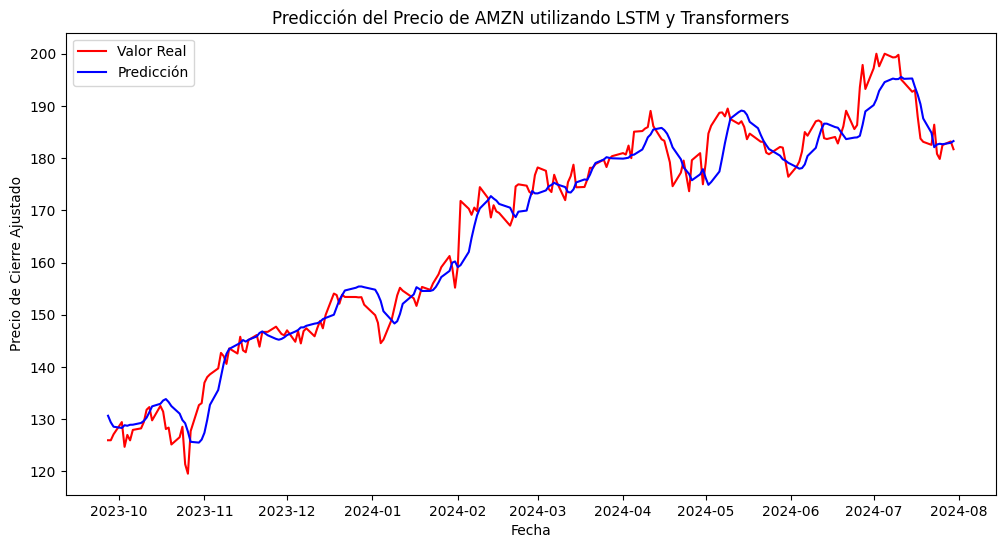

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 43.2 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
43.3 K    Trainable params
0         Non-trainable params
43.3 K    Total params
0.173     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode



Entrenando modelo para GOOGL...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Métricas para GOOGL:
MSE: 35.01680064209102
MAE: 5.046063781363301
R²: 0.8957306519389973


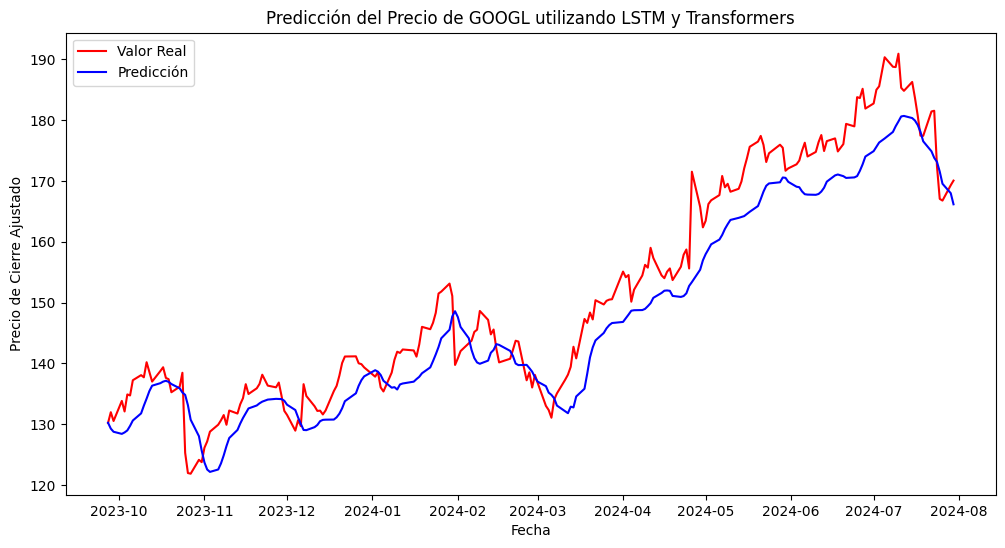

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 43.2 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
43.3 K    Trainable params
0         Non-trainable params
43.3 K    Total params
0.173     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode



Entrenando modelo para NVDA...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Métricas para NVDA:
MSE: 69.29853614147203
MAE: 5.447845643253327
R²: 0.9169995497215115


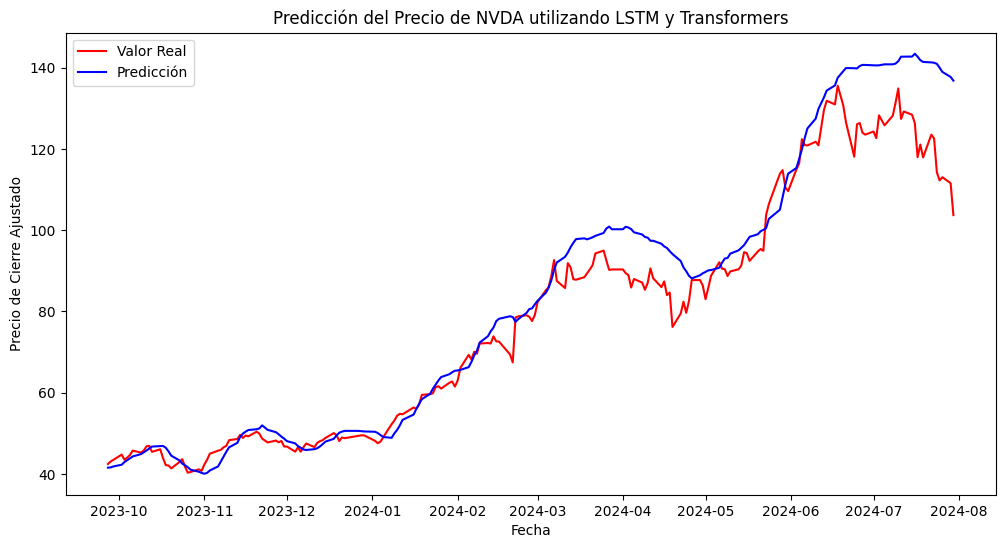

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 43.2 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
43.3 K    Trainable params
0         Non-trainable params
43.3 K    Total params
0.173     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode



Entrenando modelo para AAPL...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Métricas para AAPL:
MSE: 29.631643608142596
MAE: 4.242181234254525
R²: 0.8922145321076965


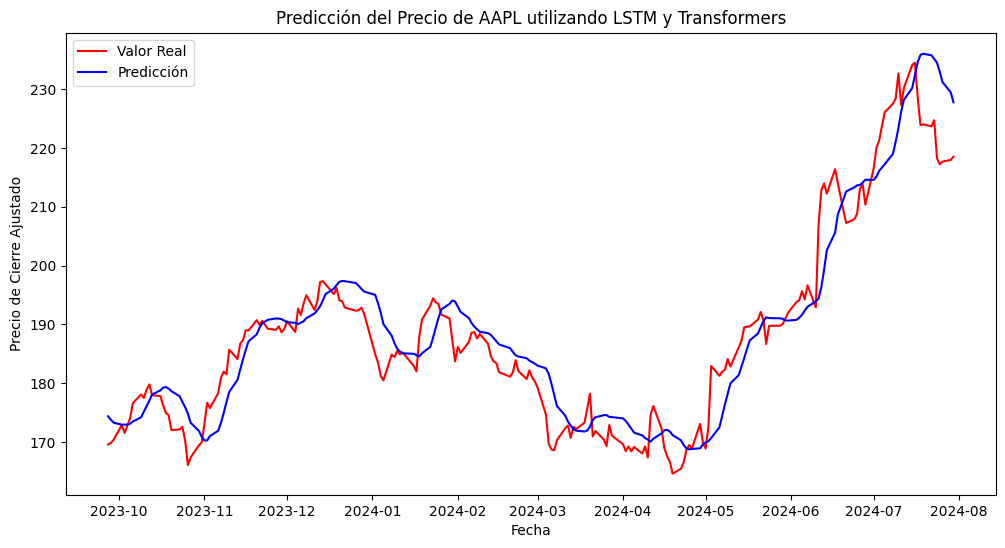

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 43.2 K | train
1 | linear    | Linear  | 101    | train
2 | criterion | MSELoss | 0      | train
----------------------------------------------
43.3 K    Trainable params
0         Non-trainable params
43.3 K    Total params
0.173     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode



Entrenando modelo para NFLX...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Métricas para NFLX:
MSE: 253.98689764743108
MAE: 11.775697913621611
R²: 0.9713450312845882


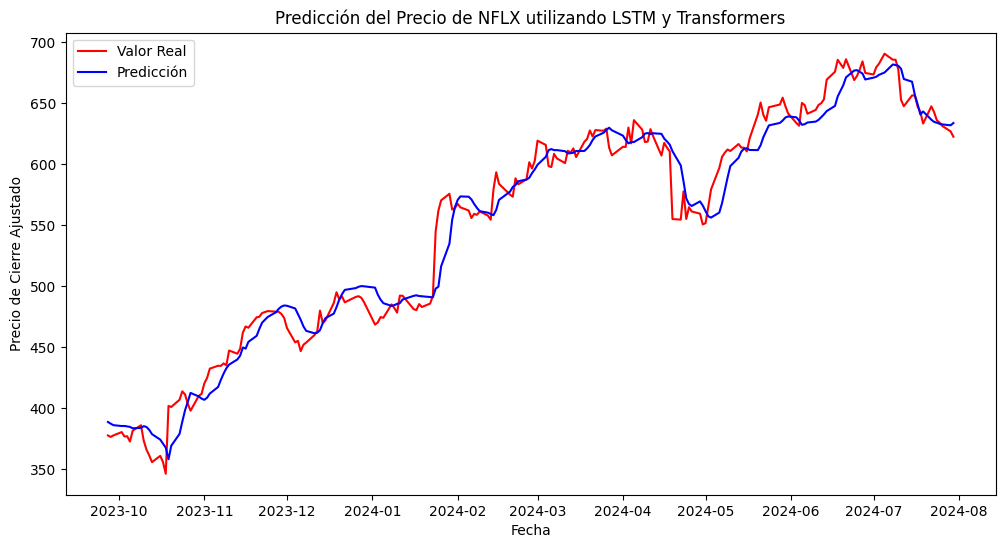


Métricas de Rendimiento:
  ticker         mse        mae        r2
0   AMZN   14.667033   2.907917  0.967148
1  GOOGL   35.016801   5.046064  0.895731
2   NVDA   69.298536   5.447846  0.917000
3   AAPL   29.631644   4.242181  0.892215
4   NFLX  253.986898  11.775698  0.971345


In [ ]:
# Agregar sentimiento de noticias al conjunto de datos
stock_data = agregar_sentimiento_noticias(stock_data)

# Lista para almacenar los resultados
results = []

for ticker in tickers:
    result = train_and_evaluate_model(ticker)
    results.append(result)

# Crear un DataFrame con las métricas
metrics_df = pd.DataFrame(results)

print("\nMétricas de Rendimiento:")
print(metrics_df)


### **REPORTES DE VERIFICACION**

In [ ]:
def generar_reporte_noticias(tickers, start_date, end_date, output_file='reporte_noticias.csv'):
    rows = []

    for ticker in tickers:
        print(f"Extrayendo noticias para {ticker} desde {start_date} hasta {end_date}...")
        noticias_por_fecha = obtener_noticias_yahoo(ticker, start_date, end_date)

        for fecha, noticias in noticias_por_fecha.items():
            for noticia in noticias:
                sentimiento = analizar_sentimiento_finbert(noticia)
                rows.append({
                    'Ticker': ticker,
                    'Fecha': fecha,
                    'Noticia': noticia,
                    'Sentimiento': sentimiento
                })

    # Convertir los datos en un DataFrame
    noticias_df = pd.DataFrame(rows)

    # Guardar en un archivo CSV
    noticias_df.to_csv(output_file, index=False)
    print(f"Reporte de noticias generado: {output_file}")

# Llamar a la función para generar el reporte
start_date = '2023-01-01'
end_date = '2023-07-31'
generar_reporte_noticias(tickers, start_date, end_date)


Extrayendo noticias para AMZN desde 2023-01-01 hasta 2023-07-31...
Extrayendo noticias para GOOGL desde 2023-01-01 hasta 2023-07-31...
Extrayendo noticias para NVDA desde 2023-01-01 hasta 2023-07-31...
Extrayendo noticias para AAPL desde 2023-01-01 hasta 2023-07-31...
Extrayendo noticias para NFLX desde 2023-01-01 hasta 2023-07-31...
Reporte de noticias generado: reporte_noticias.csv


## Crear un Reporte de Noticias de Yahoo Finance

In [ ]:
def generar_reporte_reddit(tickers, output_file='reporte_reddit.csv'):
    rows = []

    async def process_tickers():
        for ticker in tickers:
            print(f"Extrayendo publicaciones de Reddit para {ticker}...")
            publicaciones = await obtener_reddit_async(
                ticker,
                subreddit_nombre='WallStreetBets',
                limite=1000
            )

            for post in publicaciones:
                fecha = datetime.datetime.utcfromtimestamp(post['fecha']).strftime('%Y-%m-%d')
                titulo = post['titulo']
                cuerpo = post['cuerpo']
                texto_completo = titulo + ' ' + cuerpo
                sentimiento = analizar_sentimiento_finbert(texto_completo)

                rows.append({
                    'Ticker': ticker,
                    'Fecha': fecha,
                    'Título': titulo,
                    'Cuerpo': cuerpo,
                    'Sentimiento': sentimiento
                })

    # Ejecutar la función asíncrona
    asyncio.run(process_tickers())

    # Convertir los datos en un DataFrame
    reddit_df = pd.DataFrame(rows)

    # Guardar en un archivo CSV
    reddit_df.to_csv(output_file, index=False)
    print(f"Reporte de Reddit generado: {output_file}")

# Llamar a la función para generar el reporte
generar_reporte_reddit(tickers)


Extrayendo publicaciones de Reddit para AMZN...
Extrayendo publicaciones de Reddit para GOOGL...
Extrayendo publicaciones de Reddit para NVDA...
Extrayendo publicaciones de Reddit para AAPL...
Extrayendo publicaciones de Reddit para NFLX...
Reporte de Reddit generado: reporte_reddit.csv


# **PORTAFOLIO**

Rendimientos esperados diarios:
AMZN     0.001626
GOOGL    0.001410
NVDA     0.006003
AAPL     0.000927
NFLX     0.002380
dtype: float64

Matriz de covarianza diaria:
           AMZN     GOOGL      NVDA      AAPL      NFLX
AMZN   0.000051  0.000013  0.000031  0.000011  0.000015
GOOGL  0.000013  0.000045  0.000028  0.000023  0.000008
NVDA   0.000031  0.000028  0.000125  0.000018  0.000020
AAPL   0.000011  0.000023  0.000018  0.000039  0.000012
NFLX   0.000015  0.000008  0.000020  0.000012  0.000072
Pesos óptimos del portafolio (Top 5):
AMZN: 0.2400
GOOGL: 0.0500
NVDA: 0.3300
AAPL: 0.0500
NFLX: 0.3300

Retorno esperado del portafolio: 0.0033
Volatilidad del portafolio: 0.0062
Ratio de Sharpe del portafolio: -0.2767


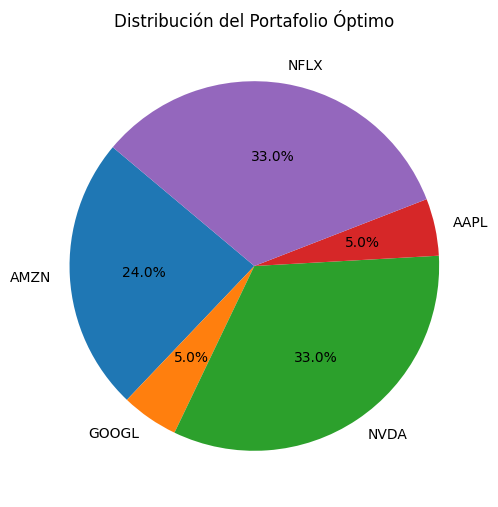

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Cálculo de rendimientos diarios esperados y matriz de covarianza
expected_returns_daily = future_prices_df.pct_change().mean()
cov_matrix_daily = future_prices_df.pct_change().cov()

# Excluir acciones con rendimientos esperados negativos
positive_return_tickers = expected_returns_daily[expected_returns_daily > 0].index
expected_returns_daily = expected_returns_daily[positive_return_tickers]
cov_matrix_daily = cov_matrix_daily.loc[positive_return_tickers, positive_return_tickers]

top_tickers = positive_return_tickers
expected_returns_daily_top = expected_returns_daily[top_tickers]
cov_matrix_daily_top = cov_matrix_daily.loc[top_tickers, top_tickers]

# Mostrar los rendimientos esperados diarios y matriz de covarianza
print("Rendimientos esperados diarios:")
print(expected_returns_daily_top)
print("\nMatriz de covarianza diaria:")
print(cov_matrix_daily_top)

# Función para calcular el rendimiento y la volatilidad del portafolio
def portfolio_performance(weights, expected_returns, cov_matrix):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_std

# Función objetivo para la optimización (maximización del Sharpe ratio)
def negative_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate=0.01):
    p_returns, p_std = portfolio_performance(weights, expected_returns, cov_matrix)
    return -(p_returns - risk_free_rate) / p_std

# Restricciones y límites para la optimización
num_assets = len(expected_returns_daily_top)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # La suma de los pesos debe ser 1
bounds = tuple((0.05, 0.33) for _ in range(num_assets))  # Limitar el peso de cada acción entre 5% y 33%

# Inicializar pesos aleatorios
initial_weights = num_assets * [1. / num_assets]

# Optimización para maximizar el Sharpe ratio
opt_results = minimize(negative_sharpe_ratio, initial_weights, args=(expected_returns_daily_top, cov_matrix_daily_top),
                       method='SLSQP', bounds=bounds, constraints=constraints)

# Pesos óptimos del portafolio
optimal_weights = opt_results.x

# Mostrar los pesos óptimos para cada acción
print("Pesos óptimos del portafolio (Top 5):")
for ticker, weight in zip(top_tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

# Evaluar el rendimiento y la volatilidad del portafolio optimizado
p_returns, p_std = portfolio_performance(optimal_weights, expected_returns_daily_top, cov_matrix_daily_top)
sharpe_ratio = (p_returns - 0.005) / p_std  # Suponiendo una tasa libre de riesgo del 0.5%

print(f"\nRetorno esperado del portafolio: {p_returns:.4f}")
print(f"Volatilidad del portafolio: {p_std:.4f}")
print(f"Ratio de Sharpe del portafolio: {sharpe_ratio:.4f}")

# Visualización de la distribución del portafolio optimizado
plt.figure(figsize=(10, 6))
plt.pie(optimal_weights, labels=top_tickers, autopct='%1.1f%%', startangle=140)
plt.title('Distribución del Portafolio Óptimo')
plt.show()